# 20133807 Jeong Seong Woon

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(),])

In [260]:
train_data_path = './horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False, num_workers=1)
validation_data_path = './horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=10, shuffle=False, num_workers=1)

## Convert Image data to matrix for calculating

In [286]:
train_data = []
train_label = []
val_data = []
val_label = []

for i, data in enumerate(trainloader):
    inputs, labels = data
    train_data_batch = []
    for j in range(len(inputs)):        
        image_temp = inputs[j][0].numpy()
        image = []
        for k in range(len(image_temp)):
            image_column = image_temp[:,k]
            image_column = image_column.reshape((100,1))
            if k==0:
                image = image_column
            else:
                image = np.vstack((image,image_column))
        image = np.vstack((image, np.ones(1)))
        if j == 0:
            train_data_batch = image
        else:
            train_data_batch = np.hstack((train_data_batch,image))
    if i == 0:
        train_data = train_data_batch
    else:
        train_data = np.hstack((train_data,train_data_batch))
    train_label = train_label+labels.tolist()
train_label = np.array(train_label)
train_label = train_label.reshape((len(train_label),1))

for i, data in enumerate(valloader):
    inputs, labels = data
    val_data_batch = []
    for j in range(len(inputs)):        
        image_temp = inputs[j][0].numpy()
        image = []
        for k in range(len(image_temp)):
            image_column = image_temp[:,k]
            image_column = image_column.reshape((100,1))
            if k==0:
                image = image_column
            else:
                image = np.vstack((image,image_column))
        image = np.vstack((image, np.ones(1)))
        if j == 0:
            val_data_batch = image
        else:
            val_data_batch = np.hstack((val_data_batch,image))
    if i == 0:
        val_data = val_data_batch
    else:
        val_data = np.hstack((val_data,val_data_batch))
    val_label = val_label+labels.tolist()
val_label = np.array(val_label)
val_label = val_label.reshape((len(val_label),1))

## Define Sigmoid function

In [268]:
def sigmoid(x):
    sig = 1/(1+np.exp(-x))
    return sig

## Define Loss function

In [295]:
def lossFunc(w, X, Y):
    m = len(Y)
    result = (-1/m)*np.sum(Y*np.log(sigmoid(np.dot(X.T,w))) + (1-Y)*np.log(1-sigmoid(np.dot(X.T,w))+0.0000001))
    return result

## Define Accuracy function

In [270]:
def accuracy(X,w):
    return sigmoid(np.dot(X.T,w)) >= 0.5

In [271]:
import time

## Define GradientDescent function through Vectorizing

In [307]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
time_list = []
# w = np.zeros((10001,1))
np.random.seed(0)
w = np.random.normal(size=(10001,1))
def gradientDescent(X, Y, w, l_rate):
    m = len(Y)
    iterations = 0
    old_train = lossFunc(w, train_data, train_label)
    old_val = lossFunc(w, val_data, val_label)
    accuracy_train = (accuracy(train_data,w) == train_label).sum() / len(train_label)
    accuracy_val = (accuracy(val_data,w) == val_label).sum() / len(val_label)
    while(True):
        iterations+=1
        loss_list_train.append(old_train)
        loss_list_val.append(old_val)
        accuracy_list_train.append(accuracy_train)
        accuracy_list_val.append(accuracy_val)
        tic = time.time()
        w = w - (l_rate/m)*np.dot(X, sigmoid(np.dot(X.T,w))-Y)
        toc = time.time()
        time_list.append((toc-tic)*1000)
        current_train = lossFunc(w, train_data, train_label)
        old_val = lossFunc(w, val_data, val_label)
        accuracy_train = (accuracy(train_data,w) == train_label).sum() / len(train_label)
        accuracy_val = (accuracy(val_data,w) == val_label).sum() / len(val_label)
        if abs(old_train-current_train)< 1e-4:
            break
        else:
            old_train = current_train

## Run GradientDescent

In [308]:
gradientDescent(train_data, train_label, w, 0.01)

## Plotting Loss graph

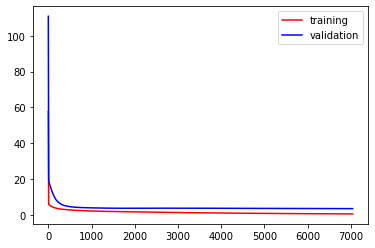

In [309]:
plt.plot(loss_list_train,label='training',color= 'r')
plt.plot(loss_list_val,label='validation',color = 'b')
plt.legend()
plt.show()

## Plotting Accuracy graph

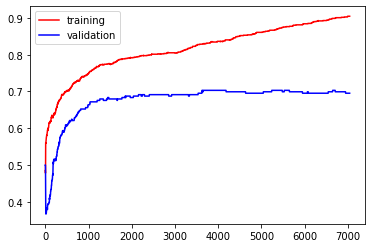

In [310]:
plt.plot(accuracy_list_train,label='training', color='r')
plt.plot(accuracy_list_val,label='validation',color='b')
plt.legend()
plt.show()

## Plot table

In [245]:
from pandas import Series, DataFrame
import pandas as pd

In [311]:
data = [[loss_list_train[-1], accuracy_list_train[-1]],
        [loss_list_val[-1], accuracy_list_val[-1]]]
frame = pd.DataFrame(data, columns = ['Loss','Accruacy'],
                        index = ['Training','Validation'])
frame

,Loss,Accruacy
Training,0.418088,0.904576
Validation,3.372746,0.695312


## Plotting time graph by milisecond

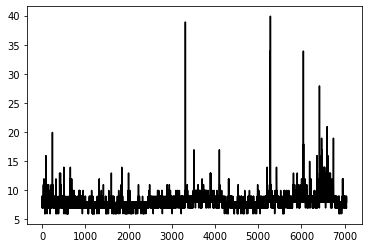

In [312]:
plt.plot(time_list, c='black')